In [1]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.modules.activation import Sigmoid
from torchinfo import summary
from pytorch_memlab import MemReporter
import time
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class conv2DBatchNormRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1):
        super(conv2DBatchNormRelu, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias=False)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        output = self.relu(x)

        return output
    
class conv2DBatchNorm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1):
        super(conv2DBatchNorm, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias=False)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        x = self.conv(x)
        output = self.batchnorm(x)

        return output

class DSconv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1):
        super(DSconv2D, self).__init__()
        self.depthwise = conv2DBatchNorm(in_channels, in_channels, kernel_size, stride, padding, dilation, groups=in_channels)
        self.pointwise = conv2DBatchNormRelu(in_channels, out_channels, kernel_size=1, padding=0)

    def forward(self, x):
        x = self.pointwise(self.depthwise(x))

        return x


class BottleNeck(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, expand_ratio=6):
        super(BottleNeck, self).__init__()
        
        mid_channels = in_channels//expand_ratio
        self.pw1 = conv2DBatchNormRelu(in_channels, mid_channels, kernel_size=1, padding=0)
        self.dw = conv2DBatchNorm(mid_channels, mid_channels, kernel_size, padding=padding)
        self.pw2 = conv2DBatchNorm(mid_channels, out_channels, kernel_size=1, padding=0)
        
    def forward(self, x):
        conv = self.pw2(self.dw(self.pw1(x)))
        return F.relu(x + conv)

    
class InvertedBottleNeck(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, expand_ratio=6):
        super(InvertedBottleNeck, self).__init__()
        
        mid_channels = in_channels*expand_ratio
        self.pw1 = conv2DBatchNormRelu(in_channels, mid_channels, kernel_size=1, padding=0)
        self.dw = conv2DBatchNorm(mid_channels, mid_channels, kernel_size, padding=padding, groups=mid_channels)
        self.pw2 = conv2DBatchNorm(mid_channels, out_channels, kernel_size=1, padding=0)
        
    def forward(self, x):
        conv = self.pw2(self.dw(self.pw1(x)))
        return F.relu(x + conv)

In [6]:
class hoge(nn.Module):
    def __init__(self, num_layer=8, num_filters=128, kernel_sizes=5):
        super(hoge, self).__init__()
        self.num_filters = num_filters
        self.convs = nn.ModuleList()
        self.convs.append(conv2DBatchNormRelu(in_channels=3, out_channels=num_filters,
                                                  kernel_size=kernel_sizes, padding=kernel_sizes//2))
        for i in range(num_layer):
#             self.convs.append(conv2DBatchNormRelu(in_channels=num_filters, out_channels=num_filters,
#                                                   kernel_size=kernel_sizes, padding=kernel_sizes//2))
            self.convs.append(DSconv2D(in_channels=num_filters, out_channels=num_filters,
                                                  kernel_size=kernel_sizes, padding=kernel_sizes//2))

#             self.convs.append(BottleNeck(in_channels=num_filters, out_channels=num_filters,
#                                                   kernel_size=kernel_sizes, padding=kernel_sizes//2))
#             self.convs.append(InvertedBottleNeck(in_channels=num_filters, out_channels=num_filters,
#                                                   kernel_size=kernel_sizes, padding=kernel_sizes//2))
            if (i==num_layer//8):
                self.convs.append(nn.MaxPool2d(2))
#                 num_filters += num_filters
            elif (i==num_layer//4):
                self.convs.append(nn.MaxPool2d(2))
#                 num_filters += num_filters
            elif (i==num_layer//2):
                self.convs.append(nn.MaxPool2d(2))
#                 num_filters += num_filters

        self.fc = nn.Linear(num_filters*4*4, 10)

    def forward(self, x):
        for i, l in enumerate(self.convs):
            x = l(x)
        x = x.view(-1, self.num_filters*4*4)
        x = self.fc(x)
        return x

Files already downloaded and verified
Files already downloaded and verified


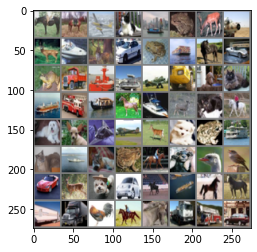

horse horse plane   cat  ship  frog  deer plane  deer  ship  deer   car  frog  ship horse   car  frog truck  ship  ship plane truck   dog   cat  ship truck  ship horse  ship  deer   cat horse   dog   dog plane plane  deer   dog  frog  ship   cat  ship   cat  frog horse   dog  bird  bird   car  deer   dog   car horse  ship horse horse truck truck  bird horse horse truck truck   car


In [7]:
def imshow(img):
    img = img / 2 + 0.5     # 非正規化
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=1)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=1)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 画像のピックアップ
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 表示
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(64)))

In [8]:
device = torch.device('cuda:0')
net = hoge(num_layer=32, num_filters=64, kernel_sizes=5).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(10):  # 総データに対する学習回数

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # データをリストに格納
        inputs = data[0].to(device)
        labels = data[1].to(device)

        # パラメータを0にリセット
        optimizer.zero_grad()

        # 順方向の計算、損失計算、バックプロパゲーション、パラメータ更新
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 計算状態の出力
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

Finished Training


In [9]:
running_loss

824.056832075119

In [ ]:
# class Dataset(torch.utils.data.Dataset):
#     def __init__(self, data, target, transform=None):
#         self.transform = transform
#         self.data = data
#         self.target = target
   
#     def __len__(self):
#         return len(self.data)
    
#     def __getitem__(self, index):
#         out_data = self.data[index]
#         out_target = self.target[index]
        
#         return out_data, out_target


In [ ]:
device = torch.device('cuda:0')
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
num = 1000
channel = 64
length = 256
input_data = torch.Tensor(num, channel, length)
target_data = torch.Tensor(num, channel, length)

batch_size=64
dataset = Dataset(input_data, target_data)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1)


net = hoge(num_layer=32, num_filters=64, kernel_sizes=7).to(device)
print(summary(net, (batch_size, channel, length)))
# reporter = MemReporter(net)
# reporter.report()
optimizer = optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-6, eps=1e-5)
criterion = nn.MSELoss().to(device)

net.to(device)
start = time.time()
for data, target in dataloader:
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = net(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()

finish = time.time()
print(finish-start)